In [104]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import random
from collections import Counter
from IPython.core.display import HTML
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
import statsmodels.formula.api as smf
from sklearn import tree
from sklearn import ensemble
from sklearn.model_selection import cross_val_score
import time
import re 
from sklearn.utils import resample

%matplotlib inline

# Predicting Housing Costs

I want to make a model than can predict housing prices. However, I don't just want to be able to predict the price of a house, I want insight into how the price is determined.  I want to know what aspects or features of a house are most important in determining price. 

To accomplish this, I will use data from the Melborne housing market.

In [117]:
housing = pd.read_csv('C:\Code\Data\melbourne.csv')

In [118]:
housing = housing.dropna()
print(housing.shape)
display(housing.head())

(8887, 21)


,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,...,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
2,Abbotsford,25 Bloomburg St,2,h,1035000.0,S,Biggin,4/02/2016,2.5,3067.0,...,1.0,0.0,156.0,79.0,1900.0,Yarra City Council,-37.8079,144.9934,Northern Metropolitan,4019.0
4,Abbotsford,5 Charles St,3,h,1465000.0,SP,Biggin,4/03/2017,2.5,3067.0,...,2.0,0.0,134.0,150.0,1900.0,Yarra City Council,-37.8093,144.9944,Northern Metropolitan,4019.0
6,Abbotsford,55a Park St,4,h,1600000.0,VB,Nelson,4/06/2016,2.5,3067.0,...,1.0,2.0,120.0,142.0,2014.0,Yarra City Council,-37.8072,144.9941,Northern Metropolitan,4019.0
11,Abbotsford,124 Yarra St,3,h,1876000.0,S,Nelson,7/05/2016,2.5,3067.0,...,2.0,0.0,245.0,210.0,1910.0,Yarra City Council,-37.8024,144.9993,Northern Metropolitan,4019.0
14,Abbotsford,98 Charles St,2,h,1636000.0,S,Nelson,8/10/2016,2.5,3067.0,...,1.0,2.0,256.0,107.0,1890.0,Yarra City Council,-37.8060,144.9954,Northern Metropolitan,4019.0


The data has 8887 rows by 21 columns. 


# Modeling the Data 

Data is too large for more complex models, I can only model part of it. As such, I will split the data into training and testing splits of data. Additionally, I will drop the columns, 'SellerG' (real estate agent), 'Address'(address of the house), 'Lattitude', 'Longtitude', and 'Distance'(distance to agent) columns.

In [111]:
# initialize variables
X = housing.drop(housing[['Price','SellerG','Address','Lattitude','Longtitude','Distance']], 1)
Y = housing['Price']
# get dummy variables for x
X = pd.get_dummies(X)
X = X.dropna()

### Decision Tree

I will first try a decision tree model. These worth by introducing feature-based rules to reduce the amount of informational entropy in the data.  Even though they cannot tell me feature importance alone, they are the basis of models that can. 

In [98]:
# Initialize and train our tree.
decision_tree = tree.DecisionTreeRegressor(
    max_features=2,
    max_depth=4,
)

decision_tree.fit(X, Y)
print("R squared for Decision Tree:")
print(decision_tree.score(X,Y))
score_tree = cross_val_score(decision_tree, X, Y, cv=10)
print("\nError: %0.2f (+/- %0.2f)" % (score_tree.mean(), score_tree.std() * 2))

R squared for Decision Tree:
0.33433580624583004

Error: 0.06 (+/- 0.32)


The decision tree model was not very good, but that is expected. Decision Trees are very simple and heavily overfit, so they do not usually make good models by themselves.

### Random Forest

The next model I will use is a Random Forest. I works by model hundreds or thousands of decision trees simultaneously and using the combined results of all of them to come up with a prediction.  Unlike decision trees, random forests can give features importance. It determines their importances based on how many times a features appears in all of it many decision trees.

In [112]:
rfr = ensemble.RandomForestRegressor()
rfr.fit(X,Y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [113]:
print("R squared for Random Forest:")
print(rfr.score(X,Y))
score_ols = cross_val_score(rfr, X, Y, cv=10)
print("\nError: %0.2f (+/- %0.2f)" % (score_ols.mean(), score_ols.std() * 2))

R squared for Random Forest:
0.9615484637878342

Error: 0.74 (+/- 0.11)


The random forest fits much better than the decsion tree, as to be expected. It is accurate enough, but the cross validation score is worrying, and indicates that there might be some overfitting.

### Gradient Boosted Decision Tree

The last model I'll use is a Boosted Decsion Tree. These work by iteratively running decision trees on the data over and over again.  When one decision tree is done, the next tree focuses on modeling its error, until a stopping point is reached.  It is able to tell features importances in much the same way as random forests.

In [114]:
gbr = ensemble.GradientBoostingRegressor()
gbr.fit(X,Y)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)

In [115]:
print("R squared for Gradient Boosted Decision Trees:")
print(gbr.score(X,Y))
score_ols = cross_val_score(gbr, X, Y, cv=10)
print("\nError: %0.2f (+/- %0.2f)" % (score_ols.mean(), score_ols.std() * 2))

R squared for Gradient Boosted Decision Trees:
0.8098013123669009

Error: 0.74 (+/- 0.09)


The boosted decision tree seems to function overall worse than the random forest, having much worse error and showing slightly more signs of being overfit. I will use my random forest model. 

# Finding Feature Importance

Now that I know I have a model I can rely on, I will determine the feature imporance according to my model

In [124]:
feature_importance = rfr.feature_importances_

# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
# sort importances
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

# split dummy names apart
dummy_fnames = pd.Series(X.columns[sorted_idx])
dummy_fsplit = dummy_fnames.str.split('_')

# create of list of the original column of each dummy variable
feature_names =[]
for n in dummy_fsplit:
    feature_names.append(n[0])
    
# initiate feature importance dataframe    
fi = pd.DataFrame()
fi['name'] = feature_names
fi['importance'] = pos

# average the importance of all features
fi = fi.groupby('name').mean()
# sort fi by importance
fi = fi.sort_values(by='importance')
# set feature importance relative to a max
fi['importance'] = 100.0 * (fi['importance'] / fi['importance'].max())

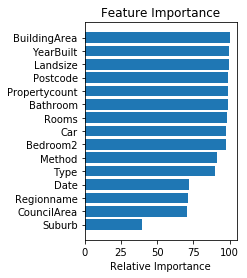

In [125]:
# plot importances
plt.subplot(1, 2, 2)
plt.barh(list(fi.index), fi['importance'], align='center')
plt.yticks(list(fi.index))
plt.xlabel('Relative Importance')
plt.title('Feature Importance')
plt.show()

It seems that BuildingArea, or the size of the house, is the most important feautre in determining it's price.  After that, the year the house was built, it's landsize, it's postal code, the number of properties in the community, number of rooms, bathrooms, bedroom, and car parking spots are all very important as well.  Next, the method used to sell the house and the type of property the house is are important. Then, the date the house went on the market, and the city and community area of the house are not as important.  Finally, the suburb the house resides in is the least important.  

https://www.kaggle.com/anthonypino/melbourne-housing-market